# Naive Bayes NB - Algorithm

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>F
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


## Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore",'detected Windows; aliasing chunkize to chunkize_serial')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from collections import Counter

## Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv("C:\\VipinML\\Assignment 2\\Assignments_DonorsChoose_2018\\train_data.csv")
resource_data = pd.read_csv("C:\\VipinML\Assignment 2\\Assignments_DonorsChoose_2018\\resources.csv")
#Limit the data for testing purpose since processing takes few hours for full set..

project_data = project_data.head(1000)
resource_data = resource_data.head(1000)


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (1000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1


### Collect All Features into global List

In [6]:
# Create list of features to appned all the features for BoW, TFIDF and std catagories.
features_bow =[]
features_tfidf= []
features_std =[]

## 1.2 preprocessing of `project_subject_categories`

In [7]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
sent = decontracted(project_data['project_essay_1'].values[500])
print(sent[1:200])
print("="*100)

y students are our future. They come in ready to learn and engage with each other, and to engage in learning science and social studies - the subjects I teach. \r\n\r\nAs a class we love, love, love 


In [9]:
def preprocesssing_cleanup(text):
    # Combining all the above stundents 
   
    from tqdm import tqdm
    X_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text):
        print (sentance)
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        X_text.append(sent.lower().strip())
       # print (X_train_preprocessed_essays)
    return X_text

    

In [10]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [11]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))



In [12]:
teacher_cat = list(project_data['teacher_prefix'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in teacher_cat:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
    temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
    temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())


project_data.drop(['teacher_prefix'], axis=1, inplace=True)
project_data['teacher_prefix'] = sub_cat_list
    
from collections import Counter
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_teacher_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 Text preprocessing

In [13]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [14]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...


In [15]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent[1:200])
print(sent[1:200])

y students are our future. They come in ready to learn and engage with each other, and to engage in learning science and social studies - the subjects I teach.     As a class we love, love, love to d
y students are our future. They come in ready to learn and engage with each other, and to engage in learning science and social studies - the subjects I teach.     As a class we love, love, love to d


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent[1:200])

y students are our future They come in ready to learn and engage with each other and to engage in learning science and social studies the subjects I teach As a class we love love love to do experimen


In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 1.4.3 Merging price with project_data

In [18]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
print (price_data[1:3])
project_data.head(1)

        id   price  quantity
1  p003483   81.28        40
2  p006068  557.98        16


,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,NaN,NaN


In [19]:
#Convert NaN value to mean of the column
project_data.fillna(project_data.mean(), inplace=True)
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,103.01,4.0


## Splitting data into Train and cross validation(or test): Stratified Sampling

In [20]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [21]:
catogories_essay = list(project_data['essay'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_essay_list = []
for i in catogories_essay:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_essay_list.append(temp.strip())
    
project_data['clean_essay'] = cat_essay_list

from collections import Counter
my_counter = Counter()
for word in project_data['clean_essay'].values:
    my_counter.update(word.split())

cat_essay_dict = dict(my_counter)
sorted_cat_essay_dict = dict(sorted(cat_essay_dict.items(), key=lambda kv: kv[1]))



In [22]:
catogories_title = list(project_data['project_title'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
project_title_list = []
for i in catogories_title:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    project_title_list.append(temp.strip())

#project_data.drop('project_title', axis=1, inplace=True)
#project_data['project_title'] = project_title_list

from collections import Counter
my_counter = Counter()
for word in project_data['project_title'].values:
    my_counter.update(word.split())

project_title_dict = dict(my_counter)
sorted_project_title_dict = dict(sorted(project_title_dict.items(), key=lambda kv: kv[1]))

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
X_train_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_train_preprocessed_essays.append(sent.lower().strip())

100%|██████████| 448/448 [00:00<00:00, 1731.70it/s]


In [24]:
# Combining all the above stundents 
from tqdm import tqdm
X_test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_test_preprocessed_essays.append(sent.lower().strip())
    

100%|██████████| 330/330 [00:00<00:00, 1657.18it/s]


In [25]:
# Combining all the above stundents 
from tqdm import tqdm
X_cv_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_cv_preprocessed_essays.append(sent.lower().strip())
    

100%|██████████| 222/222 [00:00<00:00, 1698.71it/s]


## Step 3: Standardize (normalize) the data scale to prep for Naive Bayes algorithm.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. 

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### Vectorization of clean_categories for X_train,X_test, X_cv

In [26]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_clean_cat = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=100, vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
X_train_categories_one_hot = vectorizer_clean_cat.transform(X_train['clean_categories'].values)
X_test_categories_one_hot = vectorizer_clean_cat.transform(X_test['clean_categories'].values)
X_cv_categories_one_hot = vectorizer_clean_cat.transform(X_cv['clean_categories'].values)
print(vectorizer_clean_cat.get_feature_names())
print("Shape of matrix X_train_categories_one_hot  after one hot encodig ",X_train_categories_one_hot.shape)
print("Shape of matrix X_test_categories_one_hot after one hot encodig ",X_test_categories_one_hot.shape)
print("Shape of matrix X_cv_categories_one_hot after one hot encodig ",X_cv_categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix X_train_categories_one_hot  after one hot encodig  (448, 9)
Shape of matrix X_test_categories_one_hot after one hot encodig  (330, 9)
Shape of matrix X_cv_categories_one_hot after one hot encodig  (222, 9)


### Vectorization of clean_subcategories for X_train,X_test, X_cv

In [27]:
# we use count vectorizer to convert the values into one 
vectorizer_sub_cat = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=100,vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
X_train_sub_categories_one_hot = vectorizer_sub_cat.transform(X_train['clean_subcategories'].values)
X_test_sub_categories_one_hot = vectorizer_sub_cat.transform(X_test['clean_subcategories'].values)
X_cv_sub_categories_one_hot = vectorizer_sub_cat.transform(X_cv['clean_subcategories'].values)


features_tfidf.extend(vectorizer_sub_cat.get_feature_names())
features_std.extend(vectorizer_sub_cat.get_feature_names())
features_bow.extend(vectorizer_sub_cat.get_feature_names())

print(vectorizer_sub_cat.get_feature_names())
print("Shape of matrix X_train_sub_categories_one_hot  after one hot encodig ",X_train_sub_categories_one_hot.shape)
print("Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig ",X_test_sub_categories_one_hot.shape)
print("Shape of matrixX_cv_sub_categories_one_hot after one hot encodig ",X_cv_sub_categories_one_hot.shape)

['Extracurricular', 'Economics', 'FinancialLiteracy', 'ForeignLanguages', 'CommunityService', 'ParentInvolvement', 'Civics_Government', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'History_Geography', 'PerformingArts', 'College_CareerPrep', 'Other', 'ESL', 'Health_LifeScience', 'EarlyDevelopment', 'Music', 'Gym_Fitness', 'VisualArts', 'EnvironmentalScience', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix X_train_sub_categories_one_hot  after one hot encodig  (448, 30)
Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig  (330, 30)
Shape of matrixX_cv_sub_categories_one_hot after one hot encodig  (222, 30)


In [28]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

### 1.4.2 Vectorizing Text data

In [29]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('C:\\VipinML\\InputData\\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### Vectorization of preprocessed_essays for X_train,X_test, X_cv

In [30]:
# average Word2Vec
# compute average word2vec for each review.
X_train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors.append(vector)

print(len(X_train_avg_w2v_vectors))
print(len(X_train_avg_w2v_vectors[0]))

100%|██████████| 448/448 [00:00<00:00, 2715.90it/s]


448
300


In [31]:
# average Word2Vec
# compute average word2vec for each review.
X_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors.append(vector)

print(len(X_test_avg_w2v_vectors))
print(len(X_test_avg_w2v_vectors[0]))

100%|██████████| 330/330 [00:00<00:00, 2506.69it/s]


330
300


In [32]:
# average Word2Vec
# compute average word2vec for each review.
X_cv_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_avg_w2v_vectors.append(vector)

print(len(X_cv_avg_w2v_vectors))
print(len(X_cv_avg_w2v_vectors[0]))

100%|██████████| 222/222 [00:00<00:00, 2501.04it/s]


222
300


### Vectorization of teacher_prefix  for X_train,X_test, X_cv

In [33]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_teacher_prefix = CountVectorizer(min_df=10,ngram_range=(1,4), vocabulary=list(sorted_teacher_dict.keys()),max_features=100, lowercase=False, binary=True)
X_train_teacher_prefix_data = X_train['teacher_prefix']

X_train_teacher_prefix_data.fillna("Mrs.", inplace = True) 

teacher_prefix_notnull = X_train_teacher_prefix_data[pd.notnull(X_train_teacher_prefix_data)]

vectorizer_teacher_prefix.fit(teacher_prefix_notnull.values)

X_train_teacher_prefix_one_hot = vectorizer_teacher_prefix.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_train_teacher_prefix_one_hot.shape)

features_bow.extend(vectorizer_teacher_prefix.get_feature_names())
features_tfidf.extend(vectorizer_teacher_prefix.get_feature_names())
features_std.extend(vectorizer_teacher_prefix.get_feature_names())



Shape of matrix after one hot encodig  (448, 30)


In [34]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_test_teacher_prefix_data = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=100,vocabulary=list(sorted_teacher_dict.keys()), lowercase=False, binary=True)
X_test_teacher_prefix_data = X_test['teacher_prefix']
X_test_teacher_prefix_data.fillna("Mrs.", inplace = True) 
teacher_prefix_notnull = X_test_teacher_prefix_data[pd.notnull(X_test_teacher_prefix_data)]
vectorizer_test_teacher_prefix_data.fit(teacher_prefix_notnull.values)
X_test_teacher_prefix_one_hot = vectorizer_test_teacher_prefix_data.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_test_teacher_prefix_one_hot.shape)


Shape of matrix after one hot encodig  (330, 30)


In [35]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cv_teacher_prefix = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=100,vocabulary=list(sorted_teacher_dict.keys()), lowercase=False, binary=True)
X_cv_teacher_prefix_data = X_cv['teacher_prefix']
X_cv_teacher_prefix_data.fillna("Mrs.", inplace = True) 
teacher_prefix_notnull = X_cv_teacher_prefix_data[pd.notnull(X_cv_teacher_prefix_data)]
vectorizer_cv_teacher_prefix.fit(teacher_prefix_notnull.values)
print(vectorizer_cv_teacher_prefix.get_feature_names())
X_cv_teacher_prefix_one_hot = vectorizer_cv_teacher_prefix.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_cv_teacher_prefix_one_hot.shape)


['Extracurricular', 'Economics', 'FinancialLiteracy', 'ForeignLanguages', 'CommunityService', 'ParentInvolvement', 'Civics_Government', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'History_Geography', 'PerformingArts', 'College_CareerPrep', 'Other', 'ESL', 'Health_LifeScience', 'EarlyDevelopment', 'Music', 'Gym_Fitness', 'VisualArts', 'EnvironmentalScience', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (222, 30)


### Vectorization of price for X_train,X_test, X_cv

In [36]:
X_train.head(1)
X_test.head(1)
X_cv.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
321,38079,p027296,36c0911c48c1fd8da64c378594adb98b,CA,2016-08-23 19:31:14,Grades 3-5,Engaging Ourselves With Technology,We are a diverse group of students located in ...,There are so many uses for an iPad in the clas...,NaN,NaN,My students need an iPad to engage themselves ...,1,AppliedLearning Math_Science,CharacterEducation Mathematics,CharacterEducation Mathematics,We are a diverse group of students located in ...,103.01,4.0


In [37]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

#normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print("="*100)

After vectorizations
(448, 1) (448,)
(330, 1) (330,)
(222, 1) (222,)


## Bag of words of project_title for X_train,X_test, X_cv

In [38]:
# PROJECT_TITLE BOW
# We are considering only the words which appeared in at least 10 documents(rows or projects). 
vectorizer_bow_project_title = CountVectorizer(min_df=10,ngram_range=(1,4),vocabulary=list(sorted_project_title_dict.keys()))
X_train_project_title_bow = vectorizer_bow_project_title.fit_transform(X_train['project_title'])
X_test_project_title_bow = vectorizer_bow_project_title.transform(X_test['project_title'])
X_cv_project_title_bow = vectorizer_bow_project_title.transform(X_cv['project_title'])
print("Shape of matrix X_train_project_title_bow after one hot encodig ",X_train_project_title_bow .shape)
print("Shape of matrix X_test_project_title_bow after one hot encodig ",X_test_project_title_bow .shape)
print("Shape of matrix X_cv_project_title_bow after one hot encodig ",X_cv_project_title_bow .shape)

features_bow.extend(vectorizer_bow_project_title.get_feature_names())

Shape of matrix X_train_project_title_bow after one hot encodig  (448, 2121)
Shape of matrix X_test_project_title_bow after one hot encodig  (330, 2121)
Shape of matrix X_cv_project_title_bow after one hot encodig  (222, 2121)


## Bag of words of preprocessed_essays for X_train,X_test, X_cv

In [39]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_bow_essays = CountVectorizer(min_df=10)
X_train_text_bow = vectorizer_bow_essays.fit_transform(X_train_preprocessed_essays)
X_test_text_bow = vectorizer_bow_essays.transform(X_test_preprocessed_essays)
X_cv_text_bow = vectorizer_bow_essays.transform(X_cv_preprocessed_essays)

features_bow.extend(vectorizer_bow_essays.get_feature_names())

#print (vectorizer_bow_essays.get_feature_names())
print("Shape of matrix X_train_text_bow after one hot encodig ",X_train_text_bow.shape)
print("Shape of matrix X_test_text_bow after one hot encodig ",X_test_text_bow.shape)
print("Shape of matrix X_cv_text_bow after one hot encodig ",X_cv_text_bow.shape)


Shape of matrix X_train_text_bow after one hot encodig  (448, 973)
Shape of matrix X_test_text_bow after one hot encodig  (330, 973)
Shape of matrix X_cv_text_bow after one hot encodig  (222, 973)


## TFIDF of preprocessed_essays for X_train,X_test, X_cv

In [40]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
X_train_tfidf_words = set(tfidf_model.get_feature_names())

## TFIDF of preprocessed_essays for X_train,X_test, X_cv

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essays = TfidfVectorizer()
X_train_text_tfidf = vectorizer_tfidf_essays.fit_transform(X_train_preprocessed_essays)
X_test_text_tfidf = vectorizer_tfidf_essays.transform(X_test_preprocessed_essays)
X_cv_text_tfidf = vectorizer_tfidf_essays.transform(X_cv_preprocessed_essays)
print("Shape of matrix X_train_text_tfidf after one hot encodig ",X_train_text_tfidf.shape)
print("Shape of matrix X_test_text_tfidf after one hot encodig ",X_test_text_tfidf.shape)
print("Shape of matrix X_cv_text_tfidf after one hot encodig ",X_cv_text_tfidf.shape)

features_tfidf.extend(vectorizer_tfidf_essays.get_feature_names())


Shape of matrix X_train_text_tfidf after one hot encodig  (448, 6282)
Shape of matrix X_test_text_tfidf after one hot encodig  (330, 6282)
Shape of matrix X_cv_text_tfidf after one hot encodig  (222, 6282)


## TFIDF of Project Title for X_train,X_test, X_cv

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_project_title = TfidfVectorizer(min_df=10)
X_train_project_title_tfidf = vectorizer_tfidf_project_title.fit_transform((X_train['project_title']))
X_test_project_title_tfidf = vectorizer_tfidf_project_title.transform((X_test['project_title']))
X_cv_project_title_tfidf = vectorizer_tfidf_project_title.transform((X_cv['project_title']))
print("Shape of matrix  X_train_project_title_tfidf after one hot encodig ",X_train_project_title_tfidf.shape)
print("Shape of matrix  X_test_project_title_tfidf after one hot encodig ",X_test_project_title_tfidf.shape)
print("Shape of matrix  X_cv_project_title_tfidf after one hot encodig ",X_cv_project_title_tfidf.shape)

features_tfidf.extend(vectorizer_tfidf_project_title.get_feature_names())


Shape of matrix  X_train_project_title_tfidf after one hot encodig  (448, 33)
Shape of matrix  X_test_project_title_tfidf after one hot encodig  (330, 33)
Shape of matrix  X_cv_project_title_tfidf after one hot encodig  (222, 33)


### TFIDF AVG W2V for Project Title for X_train,X_test, X_cv

In [43]:
# average Word2Vec
# compute average word2vec for each review.
X_train_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_project_title_avg_w2v_vectors.append(vector)

print(len(X_train_project_title_avg_w2v_vectors))
print(len(X_train_project_title_avg_w2v_vectors[0]))

100%|██████████| 448/448 [00:00<00:00, 112282.53it/s]


448
300


In [44]:
# average Word2Vec
# compute average word2vec for each review.
X_test_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_project_title_avg_w2v_vectors.append(vector)

print(len(X_test_project_title_avg_w2v_vectors))
print(len(X_test_project_title_avg_w2v_vectors[0]))

100%|██████████| 330/330 [00:00<00:00, 109763.70it/s]


330
300


In [45]:
# average Word2Vec
# compute average word2vec for each review.
X_cv_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_project_title_avg_w2v_vectors.append(vector)

print(len(X_cv_project_title_avg_w2v_vectors))
print(len(X_cv_project_title_avg_w2v_vectors[0]))

100%|██████████| 222/222 [00:00<00:00, 74158.61it/s]


222
300


In [46]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


X_tr = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot)).tocsr()
X_cr = hstack((X_cv_price_norm,X_cv_sub_categories_one_hot,X_cv_teacher_prefix_one_hot)).tocsr()
X_te = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot)).tocsr()

#print (X_train_price_norm)
X_tr_bow = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_text_bow,X_train_project_title_bow)).tocsr()
X_cr_bow = hstack((X_cv_price_norm,X_cv_sub_categories_one_hot,X_cv_teacher_prefix_one_hot,X_cv_text_bow,X_cv_project_title_bow)).tocsr()
X_te_bow = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_text_bow,X_test_project_title_bow)).tocsr()


#print (X_train_price_norm)
#X_tr_bow = hstack((X_train_price_norm,,X_train_teacher_prefix_one_hot,X_train_text_bow,X_train_project_title_bow)).tocsr()
#X_cr_bow = hstack((X_cv_price_norm,,X_cv_teacher_prefix_one_hot,X_cv_text_bow,X_cv_project_title_bow)).tocsr()
#X_te_bow = hstack((X_test_price_norm,,X_test_teacher_prefix_one_hot,X_test_text_bow,X_test_project_title_bow)).tocsr()


X_tr_tfidf = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_tfidf,X_train_text_tfidf)).tocsr()
X_cr_tfidf = hstack((X_cv_sub_categories_one_hot,X_cv_teacher_prefix_one_hot,X_cv_price_norm,X_cv_project_title_tfidf,X_cv_text_tfidf)).tocsr()
X_te_tfidf = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_tfidf,X_test_text_tfidf)).tocsr()

X_tr_tfidf_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_cr_tfidf_w2v = hstack((X_cv_sub_categories_one_hot,X_cv_teacher_prefix_one_hot,X_cv_price_norm,X_cv_project_title_avg_w2v_vectors)).tocsr()
X_te_tfidf_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()


X_tr_avg_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_cr_avg_w2v = hstack((X_cv_sub_categories_one_hot,X_cv_teacher_prefix_one_hot,X_cv_price_norm,X_cv_project_title_avg_w2v_vectors)).tocsr()
X_te_avg_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()

#print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

print("="*100)

print(X_tr_tfidf.shape, y_train.shape)
print(X_cr_tfidf.shape, y_cv.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)



(448, 61) (448,)
(222, 61) (222,)
(330, 61) (330,)
(448, 6376) (448,)
(222, 6376) (222,)
(330, 6376) (330,)


# Assignment 4: Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Naive Bayes Validation </h1>

<h2>2.4 Appling NB() on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Naive Bayes on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [47]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [48]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [49]:
def multinomialNB_validation_alpha_analysis(X_tr,y_train,X_te,y_test):
    import matplotlib.pyplot as plt
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
   
    #alphas = np.logspace(-1, 100, num=10)
    alphas = [0,0.00001, 0.0006, 0.0009,0.0001, 0.0003, 0.0004, 0.0008, 0.001,0.01, 0.07,0.09, 0.1,0.2,0.3,0.4,0.5,0.9,1]
    nb = MultinomialNB()
    train_auc = []
    test_auc = []
    grid = GridSearchCV(estimator=nb,param_grid=dict(alpha= alphas),return_train_score=True)

    %time grid.fit(X_tr, y_train)
    
    print("Best grid score: %s" % grid.best_score_)
    print("Best grid estimator: %s" % grid.best_estimator_.alpha)
    
    alpha =  grid.best_estimator_.alpha
    
    NB =   grid.best_estimator_
    
    print("Best alpha is after applying GridSearchCV: %s" % alpha)

    # 4. make class predictions for X_test_dtm
    y_test_pred = grid.predict(X_te)    # 4. make class predictions for X_test_dtm
    y_train_pred = grid.predict(X_tr)

 
    
    # calculate accuracy of class predictions
    #from sklearn import metrics
    #print (metrics.accuracy_score(y_test, y_test_pred))

    #the ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("AUC PLOT")
    plt.grid()
    plt.show()
     
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

### How to speculate the performance of the model using ROC Curve?
#### An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever

In [50]:
def NB_best_validation(X_tr,y_train,X_te, y_test,best_alpha,count_vect):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    from sklearn.metrics import roc_curve, auc
    from sklearn.naive_bayes import MultinomialNB
    
    # use model MultinomialNB, pass best aplha found already in earlier analysis.
    nb = MultinomialNB(alpha=best_alpha,class_prior=[0.5,0.5])
    nb.fit(X_tr, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_train_pred = nb.predict(X_tr)
    y_test_pred = nb.predict(X_te)

    #The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    # plot AUC curve. AUC curve should show best accuracy rate, since best aplha is used in the logic.
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("AUC PLOT")
    plt.grid()
    plt.show
    
   
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    
    neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

   
    print("Top 10 positive features %s" % np.take(count_vect, pos_class_prob_sorted[:10]))
    print("="*100)
    print("Top 10 negative features %s" % np.take(count_vect, neg_class_prob_sorted[:10]))
    
  

In [51]:
def NBAnalysis_cross_validation(X_tr,y_tr,X_cr,y_cv):
    from sklearn import model_selection
    from mlxtend.plotting import plot_decision_regions
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    # Import classification report and confusion matrix to evaluate predictions
    from sklearn.metrics import classification_report, confusion_matrix
    
    # split the data set into train and test
    # Break up the data as you see test data to 30%, train data is 70%. so we break data into two matrix. 
    # x1 and y1 would be 70% as train data and x-test and y_test will be test data as 30%.
 
    error_rate = []
    
   # X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
    # split the train data set into cross validation train and cross validation test
    #X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)

    #Evaluate alternative K-values for better predictionsTo simplify the process of evaluating multiple cases of k-values, 
    #we create a function to derive the error using the average where our predictions were not equal to the test values.
    for i in  [0.0000001,0.00001,0.0001, 0.001, 0.01, 0.06,0.07,0.1, 0.2,0.3,0.4,0.5,0.9,1,2]: 
        nb = MultinomialNB(alpha=i,class_prior=[0.5,0.5]) # Number of nearest neighbor is i.

        # fitting the model on crossvalidation train
        nb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        y_pred = nb.predict(X_cr)  # predicting the value using cross validation data. 

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, y_pred, normalize=True) * float(100)  # I get the accuracy score. 
        print('\nCV accuracy for Alpha = %.6f is %d' % (i, acc))
    
        # evaluate CV accuracy
        error_rate.append(np.mean(y_pred != y_cv))
        #print (error_rate)
   
    # Configure and plot error rate over k values
    plt.figure(figsize=(10,4))
    plt.plot([0.0000001,0.00001,0.0001, 0.001, 0.01, 0.06,0.07,0.1, 0.2,0.3,0.4,0.5,0.9,1,2], error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. Alphas')
    plt.xlabel('Alphas')
    plt.ylabel('Error Rate')
       

<h2>2.4 Appling MultiNomialNB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply KMultiNomialNBNN on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instructions

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### 2.4.0  Alpha Validation  for MultinomialNB on   Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

###  Alpha Validation  for MultinomialNB

Wall time: 107 ms
Best grid score: 0.8236607142857143
Best grid estimator: 0
Best alpha is after applying GridSearchCV: 0


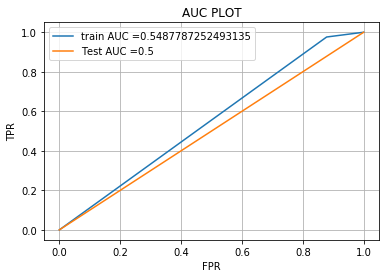

the maximum value of tpr*(1-fpr) 0.1186948981066628 for threshold 1
Train confusion matrix
[[  9  65]
 [  9 365]]
Test confusion matrix
[[  4  51]
 [ 20 255]]


In [52]:
multinomialNB_validation_alpha_analysis(X_tr,y_train,X_te,y_test)

### 2.4.1  Alpha Validation  for MultinomialNB on  BOW - Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

In [53]:
# Please write all the code with proper documentation

### kbest for BoW

Wall time: 142 ms
Best grid score: 0.8348214285714286
Best grid estimator: 0.4
Best alpha is after applying GridSearchCV: 0.4


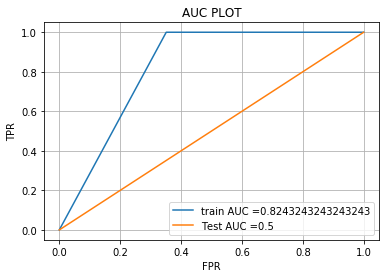

the maximum value of tpr*(1-fpr) 0.6486486486486487 for threshold 1
Train confusion matrix
[[ 48  26]
 [  0 374]]
Test confusion matrix
[[  0  37]
 [  0 185]]


In [54]:
multinomialNB_validation_alpha_analysis (X_tr_bow,y_train,X_cr_bow,y_cv)

Wall time: 135 ms
Best grid score: 0.8348214285714286
Best grid estimator: 0.4
Best alpha is after applying GridSearchCV: 0.4


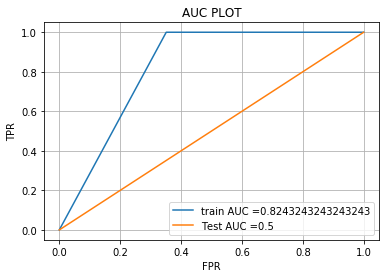

the maximum value of tpr*(1-fpr) 0.6486486486486487 for threshold 1
Train confusion matrix
[[ 48  26]
 [  0 374]]
Test confusion matrix
[[  0  37]
 [  0 185]]


In [55]:

multinomialNB_validation_alpha_analysis(X_tr_bow,y_train,X_cr_bow,y_cv)


### 2.4.2 Alpha Validation  for MultinomialNB on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>

Wall time: 148 ms
Best grid score: 0.8348214285714286
Best grid estimator: 0
Best alpha is after applying GridSearchCV: 0


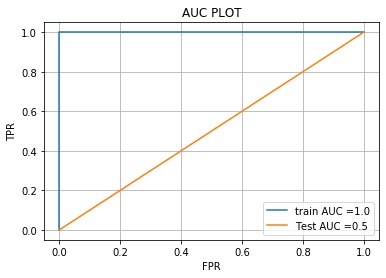

the maximum value of tpr*(1-fpr) 1.0 for threshold 1
Train confusion matrix
[[ 74   0]
 [  0 374]]
Test confusion matrix
[[  0  37]
 [  0 185]]


In [56]:
multinomialNB_validation_alpha_analysis(X_tr_tfidf,y_train,X_cr_tfidf,y_cv)

## 2.5.1 <font color='red'> Alpha-Analysis  <font color='blue'> categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>


CV accuracy for Alpha = 0.000000 is 80

CV accuracy for Alpha = 0.000010 is 80

CV accuracy for Alpha = 0.000100 is 80

CV accuracy for Alpha = 0.001000 is 80

CV accuracy for Alpha = 0.010000 is 79

CV accuracy for Alpha = 0.060000 is 77

CV accuracy for Alpha = 0.070000 is 77

CV accuracy for Alpha = 0.100000 is 78

CV accuracy for Alpha = 0.200000 is 81

CV accuracy for Alpha = 0.300000 is 81

CV accuracy for Alpha = 0.400000 is 82

CV accuracy for Alpha = 0.500000 is 83

CV accuracy for Alpha = 0.900000 is 83

CV accuracy for Alpha = 1.000000 is 83

CV accuracy for Alpha = 2.000000 is 83


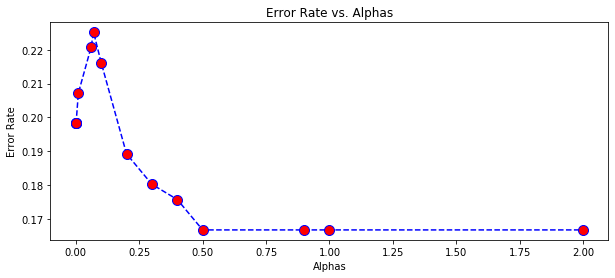

In [57]:
NBAnalysis_cross_validation(X_tr_bow,y_train,X_cr_bow,y_cv)

### 2.5.2 <font color='red'> Alpha-Analysis   <font color='blue'>  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>


CV accuracy for Alpha = 0.000000 is 83

CV accuracy for Alpha = 0.000010 is 83

CV accuracy for Alpha = 0.000100 is 83

CV accuracy for Alpha = 0.001000 is 82

CV accuracy for Alpha = 0.010000 is 80

CV accuracy for Alpha = 0.060000 is 77

CV accuracy for Alpha = 0.070000 is 78

CV accuracy for Alpha = 0.100000 is 82

CV accuracy for Alpha = 0.200000 is 83

CV accuracy for Alpha = 0.300000 is 83

CV accuracy for Alpha = 0.400000 is 83

CV accuracy for Alpha = 0.500000 is 83

CV accuracy for Alpha = 0.900000 is 83

CV accuracy for Alpha = 1.000000 is 83

CV accuracy for Alpha = 2.000000 is 83


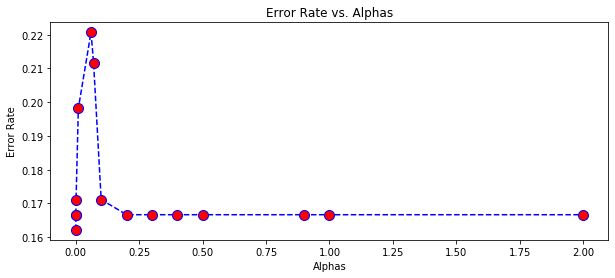

In [58]:
NBAnalysis_cross_validation(X_tr_tfidf,y_train,X_cr_tfidf,y_cv)

### 3.1 <font color='red'> ALPHA-BEST  <font color='blue'> categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

the maximum value of tpr*(1-fpr) 0.9495591848533026 for threshold 1
Train confusion matrix
[[ 72   2]
 [  9 365]]
Test confusion matrix
[[  5  32]
 [ 16 169]]
Top 10 positive features ['Clubs' 'you' 'Ipads' 'flexible' 'CAN' 'Hungry' 'Backpacks' 'Some'
 'Light' 'Computer']
Top 10 negative features ['Clubs' 'Chromebook' 'Complete' 'Desktops!' 'Experience' 'Tech' 'Can'
 'Use' 'Centers' 'Light']


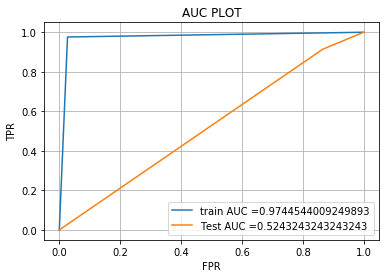

In [59]:
# Best alpha is found from above analysis of BoW. using best Alpha, test accuracy is calcuated as around.
Best_alpha=0.1
NB_best_validation(X_tr_bow,y_train,X_cr_bow, y_cv,Best_alpha,features_bow)

### 3.2 <font color='red'> Alpha-Best   <font color='blue'>  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>

the maximum value of tpr*(1-fpr) 0.0 for threshold 2
Train confusion matrix
[[ 74   0]
 [374   0]]
Test confusion matrix
[[ 37   0]
 [185   0]]
Top 10 positive features ['privilege' 'university' 'applications' 'male' 'structure' 'considerable'
 'question' 'consistent' 'striving' 'strives']
Top 10 negative features ['Extracurricular' 'modifying' 'modernize' 'modern' 'models' 'modeling'
 'model' 'modalities' 'mock' 'mixed']


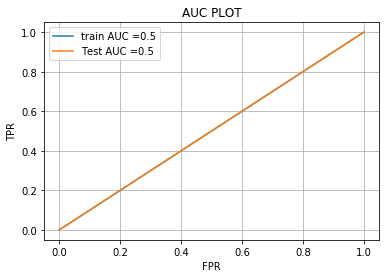

In [60]:
# Best alpha is found from above analysis of TfDIF. using best Alpha, test accuracy is calcuated as around.
Best_alpha=0.7
NB_best_validation(X_tr_tfidf,y_train,X_cr_tfidf,y_cv,Best_alpha,features_tfidf)

### 3.4 <font color='red'> Alpha-Best   <font color='blue'>  on - categorical, numerical features + project_title + preprocessed_essay ,<font color='red'> SET 4</font>

the maximum value of tpr*(1-fpr) 0.36132389073565546 for threshold 1
Train confusion matrix
[[ 50  24]
 [174 200]]
Test confusion matrix
[[17 20]
 [94 91]]
Top 10 positive features ['CommunityService' 'CommunityService' 'ParentInvolvement'
 'ParentInvolvement' 'NutritionEducation' 'Civics_Government' 'Economics'
 'FinancialLiteracy' 'ForeignLanguages' 'CharacterEducation']
Top 10 negative features ['CommunityService' 'VisualArts' 'CharacterEducation' 'Warmth'
 'NutritionEducation' 'Civics_Government' 'ForeignLanguages' 'VisualArts'
 'ParentInvolvement' 'Economics']


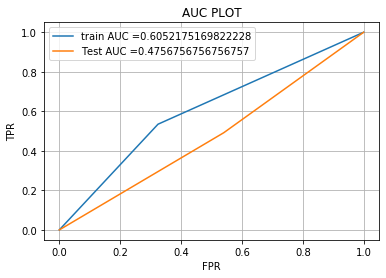

In [61]:
# Best alpha is found from above analysis of Std. using best Alpha, test accuracy is calcuated as around.
Best_alpha= 0.09
NB_best_validation(X_tr,y_train,X_cr,y_cv,Best_alpha,features_std)

<h1>3. Conclusions</h1>

## Summary of above program as below:
### Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

### Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

### Step 3: Standardize (normalize) the data scale to prep for Multinomial NB algorithm.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. Again,  Naive Bayes depends on the distance between each feature. Please see Section 1 for all normalization.

### Step 4: Split the normalized data into training and test sets.
This step is required to prepare us for the fitting (i.e. training) the model later. The “X” variable is a collection of all the features. The “y” variable is the target label which specifies the classification of 1 or 0 based. Our goal will be to identify which category the new data point should fall into.

Please see functions as covered below, used in above program: def multinomialNB_validation_alpha_analysis: def NB_best_validation

### Step 5: Create and Train the Model.
Here we create a Naive Bayes Object and use the .fit() method to train the model. Upon completion of the model we should receive confirmation that the training has been complete

Please see functions as covered below, used in above program: def multinomialNB_validation_alpha_analysis def NB_best_validation

### Step 6: Make Predictions.
Here we review where our model was accurate and where it misclassified elements.

Please see functions as covered below, used in above program: def multinomialNB_validation_alpha_analysis def NB_best_validation

### Step 7: Evaluate the predictions.
Evaluate the Model by reviewing the classification report or confusion matrix. By reviewing these tables, we are able to evaluate how accurate our model is with new values.

def multinomialNB_validation_alpha_analysis def NB_best_validation:

### Setp 8:Classification Report :
This tells us our model was around 84% accurate… Print out classification report and confusion matrix

print(classification_report(y_test, pred))

I have covered various set to show confusion matrix.

Please see section 2. covered various data sets and created confusion matrix.

### Step 9: Evaluate alternative Alpha for better predictions.
To simplify the process of evaluating multiple cases of Alpha values, we create a function to derive the error using the average where our predictions were not equal to the test values.

Please see section 2. covered various data sets and created error accuracy reports.

### Step 10: Plot Error Rate
Here we see that the error rate continues to decrease as we increase the Alpha. A picture tells a thousand words. Or at least here, we are able to understand what value of Alpha leads to an optimal model. The Alpha of 1 or 0.9 seems to give a decent error rate without too much noise.

### Step 11: Adjust Alpha value per error rate evaluations 
This is just fine tuning our model to increase accuracy. We will need to retrain our model with the new Alpha.
Please see section 3 in above program. we have created confusion matrix for optimal Alpha value for various data sets. As we can see for optimal Alpha, Accuracy is much higher - so prediction is much better.
